## Clathrate cluster analysis

This notebook contains analysis of the data used to produce results for methane in water clathrate paper.

The ordering is as follows:
* useful stuff is defined
* data is loaded
* analysis in order:
 * a
 * b

Data are usually stored in arrays with indices used to describe basis set, functional, fragment index, use of singles corrections,  ...
The indices of basis set or functional are stored in a python dictionary.


In [315]:
#import stuff
import os
import numpy as np
import matplotlib.pyplot as plt 
#our little library with some useful functions (basis-set extrapolation, getting MBE contributions, ...)
import mbe_lib as mbe

#########################
#Basis set dictionaries #
#########################

#standard basis sets
basid={}
basid['TZ']=0
basid['QZ']=1
basid['CBS']=2

#QZ and 5Z basis sets
bas5id={}
bas5id['QZ']=0
bas5id['5Z']=1
bas5id['CBS']=2

#DZ and TZ basis sets
basDTid={}
basDTid['DZ']=0
basDTid['TZ']=1
basDTid['CBS']=2

#DZ, TZ, QZ basis sets
bas24id={}
bas24id['DZ']=0
bas24id['TZ']=1
bas24id['QZ']=2
bas24id['CBS']=3

#basis names for Marcin's code
MM_basis={}
MM_basis['small-basis']=0
MM_basis['large-basis']=1
MM_basis['CBS']=2

###################
# Unit conversion #
###################
#Hartree to kcal/mol ("Marcin's units")
ha2kc=627.50960803059
#Hartree to kJ/mol ("Sirous' units")
ha2kj=2625.5002
#Hartree to eV ("Jiri's units")
ha2ev=27.211399

#########################
# DFT input eigenstates #
#########################
#for usual approximations
methods={}
methods['PBE']=0
methods['PBE0']=1
methods['SCAN']=2
methods['SCAN0']=3
methods['HF']=4

#and for OEP
oep_m={}
oep_m['oepx']=0
oep_m['oep2sc']=1
oep_m['hf']=2

##################
# Arrays for MBE #
##################
#RPA: indices are methods; RSE (no and yes); MBE order 0th, 2-body, 3-body (1hb and 0hb), 4-body (2hb, 1hb, 0hb)
RPA_mbe=np.zeros((5,2,7))
#Moller-Plesset PT, MP2, MP3, MP4; MBE order
MP_mbe=np.zeros((3,7))
#CC with AVQZ and AV5Z: method HF+CABS, CCSD-F12, (T), HF+CABS+CCSD-F12(T); MBE order 
CC_mbeQ5=np.zeros((4,7))
#CC with canonical CCSD(T)
CCcan_mbeQ5=np.zeros((4,7))

#interaction en ergies from supermolecular calculations in kcal/mol
RPA_sup=np.array([[-3.73, -4.99],[-3.30, -4.03],  [-3.38, -5.11], [-3.17, -4.18],   [0.0 ,0.0]])

In [316]:
##################################
# Trimers distance arrays set-up #
##################################

#The three-body and four-body contributions are divided according to the distance and number of hydrogen bonds
#here we calculate the distances 
#There are four groups when ordering is done according to distance
#There are two groups when orering is done according to number of hydrogen bonds

#array storing distance between pair of water molecules
dist=np.zeros((20,20))
#array storing distance between water molecules in (indexed, ordered) trimers
dist3_list=np.zeros((190))
#number of fragments assigned in groups according to distance
NN_num3=np.zeros((4))
#distance group index for a given trimer
trim_nn_case=np.zeros((190),dtype=np.int16)
# arrays for transforming from pair of molecules (n,m) list into ordered trimers (1..190) list 
trim_idx=np.zeros((20,20),dtype=np.int32)
trim_to2D=np.zeros((190,2),dtype=np.int32)

#load the distances of water molecules, they are stored in the file
idt=0
with open('data/dist_trimer.dat','r') as f:
    for i in range(19): #loop over first monomers 0 to 18
        for j in range(i+1,20):  #loop over monomers i+1 to 19
            #read the distance between molecules i and j
            dist[i,j]=float(f.readline())
            #put the conversion indices into right places
            trim_idx[i,j]=idt
            trim_to2D[idt,0]=i
            trim_to2D[idt,1]=j
            #assign the trimer to a distance group
            if dist[i,j]<3.2:
                trim_nn_case[idt]=0
            elif dist[i,j]<5.5:
                trim_nn_case[idt]=1
            elif dist[i,j]<6.75:
                trim_nn_case[idt]=2
            else:
                trim_nn_case[idt]=3
            #increase the number of trimers in the assigned group
            NN_num3[trim_nn_case[idt]]+=1
            #go to next trimer
            idt+=1
            #possibly check that things are working fine
            #if i==0:
            #    print(i,j,dist[i,j])


#############################
# Tetramers distance set-up #
#############################

#assign tetramers into groups according to the number of hydrogen bonds in the fragment (0, 1, or 2)
#distance in tetramers, stored as i,j,k and ordered tetramer index
dist_tetr=np.zeros((20,20,20))
dist_list=np.zeros((1140))
#number of nearest neighbours in tetramer
NN_num4=np.zeros((3))
#array to store the group index (number of h-bonds)
tetr_nn_num=np.zeros((1140),dtype=np.int16)
#back and forth indices between [0,i,j,k] and ordered tetramer index
tetr_idx=np.zeros((20,20,20),dtype=np.int32)
tetr_to3D=np.zeros((1141,3),dtype=np.int32)
idt=0
for i in range(18): #loop over monomers 0 to 17
    for j in range(i+1,19): #loop over i+1 to 18
        for k in range(j+1,20): #loop over j+1 to 19
            #calculate the total distance in the tetramer  (? maybe no reason for this...)
            dist_tetr[i,j,k]=dist[i,j]+dist[i,k]+dist[j,k]
            dist_list[idt]=dist_tetr[i,j,k]
            #count the number of water nearest neighbours in the tetramer
            #check the first dimer, then the second, then the last
            if dist[i,j] <3.2:
                tetr_nn_num[idt]+=1
            if dist[i,k] <3.2:
                tetr_nn_num[idt]+=1
            if dist[j,k] <3.2:
                tetr_nn_num[idt]+=1
            #add one to the array counting the number of NNs
            NN_num4[tetr_nn_num[idt]]+=1
            #store the transition matrix between i,j,k and ordered index (not sure if needed)
            tetr_idx[i,j,k]=idt
            tetr_to3D[idt,0]=i
            tetr_to3D[idt,1]=j
            tetr_to3D[idt,2]=k
            #go to next one
            idt+=1
            


In [317]:
# Few basic functions to process the data

#calculate basic statistics (total, ME, MAE, RMSD from a reference set)
#input: test   = data for which statistics is calculated
#       ref    = reference data
def calc_stat(test,ref):
    if len(test) != len(ref):
        print(len(test), len(ref), ' are different')
    ME=0.
    MAE=0.
    RMSD=0.
    #print ('Total ', np.sum(test), np.sum(ref))
    AVG1=np.sum(test)/len(ref)
    AVG2=np.sum(ref)/len(ref)
    for i in range(len(test)):
        ME+=test[i]-ref[i]
        MAE+=abs(test[i]-ref[i])
        RMSD+=(test[i]-ref[i])**2
    ME=ME/len(ref)
    MAE=MAE/len(ref)
    RMSD=np.sqrt(RMSD/len(test))
    
    #print the statistics
    print('Total  ME  MAE  RMSD')
    print(np.sum(test), ME , MAE, RMSD)

# Read data

The total energies are read from output files or from data files into arrays with _orig_ in their name, the many-body interaction energy is then calculated using mbe library and stored in array with _val_ in its name.

## Two-body energies

Reference data

* CC with accu=1e-16, orbital=1d-10, energy=1d-10, data/dimer/CC_orb10, AVTZ, AVQZ, AV5Z basis
 * stored as Molpro output files
 * read into HF_orig_o10, CCSD_orig_o10, CCSDT_orig_o10 arrays for AVTZ and AVQZ basis sets
 * read into HF_orig_o10Q5, CCSD_orig_o10Q5, CCSDT_orig_o10Q5 arrays for AVQZ and AV5Z basis sets
 
* CC-F12 with accu=1e-16, orbital=1d-10, energy=1d-10, data/dimer/CCF12_orb10, AVTZ, AVQZ, AV5Z basis 
 * stored as Molpro output files
 * read into CABS_orig_Fo10, CCSD_orig_Fo10, CCSDF12b_orig_Fo10, Ts_orig_Fo10, Tu_orig_Fo10 arrays for AVTZ and AVQZ basis sets
 * read into CABS_orig_Fo10Q5, CCSD_orig_Fo10Q5, CCSDF12b_orig_Fo10Q5, Ts_orig_Fo10Q5, Tu_orig_Fo10Q5 arrays for AVQZ and AV5Z basis sets
 
CCSD-F12 using VTZ-F12 basis set as in Deible et al.
* CC-F12 with orbital=1d-8, energy=1d-8, twoint=1.d-19, VTZ-F12 basis
 * stored as Molpro output files
 * read into CABS_orig_Fo8, CCSD_orig_Fo8, CCSDF12b_orig_Fo8, Ts_orig_Fo8, Tu_orig_Fo8 arrays for VTZ-F12 basis set

MPn
* with orbital=1d-8,energy=1d-8,twoint=1.d-19, data/dimer/MPn, AVTZ and AVQZ basis
 * stored as Molpro output files

Notes:
* Different twoint screening makes no significant difference to dimers(10^-6 kcal/mol for CC)
* Orbital and energy convergence set to 1d-8 or to 1d-10 makes no significant difference to dimers (10^-5 kcal/mol for CC)

In [318]:
#####################
# Canonical CCSD(T) #
#####################

# AVTZ and AVQZ basis set

#HF_orig, indices: basis-set (AVTZ and AVQZ); dimer index; dimer and monomer energies
#HF_val, indices: basis-set (AVTZ, AVQZ, CBS); dimer index
HF2_orig_TQ=np.zeros((2,20,3),dtype=np.float64)
HF2_val_TQ=np.zeros((3,20),dtype=np.float64)
#CCSD correlation energy
CCSD2_orig_TQ=np.zeros((2,20,3),dtype=np.float64)
CCSD2_val_TQ=np.zeros((3,20),dtype=np.float64)
#CCSD(T) correlation energy
CCSDT2_orig_TQ=np.zeros((2,20,3),dtype=np.float64)
CCSDT2_val_TQ=np.zeros((3,20),dtype=np.float64)
#(T) correlation energy
T2_val_TQ=np.zeros((3,20),dtype=np.float64)

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/CC_orb10/'+basis+'/'+str("{:02d}".format(i+1))+'_Dime_CC_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                #process the file
                filelist=f.readlines()
                # mbe.read functions process the file and return a tuple (or whatever that is) of lists
                data=mbe.read_CC_F12_Molpro(filelist)
                HF2_orig_TQ[basid[basis],i,:]=data[0]
                HF2_val_TQ[basid[basis],i]=mbe.get_2body(data[0])*ha2kc
                CCSD2_orig_TQ[basid[basis],i,:]=data[4]
                CCSD2_val_TQ[basid[basis],i]=mbe.get_2body(data[4])*ha2kc
                #read_MP4_Molpro actually looks only for "Total correlation energy"
                data=mbe.read_MP4_Molpro(filelist)
                CCSDT2_orig_TQ[basid[basis],i,:]=data
                CCSDT2_val_TQ[basid[basis],i]=mbe.get_2body(data)*ha2kc 
                #store the data in (T)
                T2_val_TQ[basid[basis],i]=CCSDT2_val_TQ[basid[basis],i]-CCSD2_val_TQ[basid[basis],i]
                
                
for i in range(20):
    CCSD2_val_TQ[basid['CBS'],i]=mbe.basis_extrap(CCSD2_val_TQ[basid['TZ'],i],CCSD2_val_TQ[basid['QZ'],i],3,4)
    CCSDT2_val_TQ[basid['CBS'],i]=mbe.basis_extrap(CCSDT2_val_TQ[basid['TZ'],i],CCSDT2_val_TQ[basid['QZ'],i],3,4)
    T2_val_TQ[basid['CBS'],i]=mbe.basis_extrap(T2_val_TQ[basid['TZ'],i],T2_val_TQ[basid['QZ'],i],3,4)
    
# AVQZ and AV5Z basis set

#Data with QZ and 5Z basis sets and canonical CCSD(T)
HF2_orig_Q5=np.zeros((2,20,3),dtype=np.float64)
HF2_val_Q5=np.zeros((3,20),dtype=np.float64)
#CCSD correlation energy
CCSD2_orig_Q5=np.zeros((2,20,3),dtype=np.float64)
CCSD2_val_Q5=np.zeros((3,20),dtype=np.float64)
#CCSD(T) correlation energy
CCSDT2_orig_Q5=np.zeros((2,20,3),dtype=np.float64)
CCSDT2_val_Q5=np.zeros((3,20),dtype=np.float64)
#T correlation
T2_val_Q5=np.zeros((3,20),dtype=np.float64)


for basis in ['QZ','5Z']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/CC_orb10/'+basis+'/'+str("{:02d}".format(i+1))+'_Dime_CC_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_CC_F12_Molpro(filelist)
                HF2_orig_Q5[bas5id[basis],i,:]=data[0]
                HF2_val_Q5[bas5id[basis],i]=mbe.get_2body(data[0])*ha2kc
                CCSD2_orig_Q5[bas5id[basis],i,:]=data[4]
                CCSD2_val_Q5[bas5id[basis],i]=mbe.get_2body(data[4])*ha2kc
                data=mbe.read_MP4_Molpro(filelist)
                CCSDT2_orig_Q5[bas5id[basis],i,:]=data
                CCSDT2_val_Q5[bas5id[basis],i]=mbe.get_2body(data)*ha2kc 
                T2_val_Q5[bas5id[basis],i]=CCSDT2_val_Q5[bas5id[basis],i]-CCSD2_val_Q5[bas5id[basis],i]

#extrapolate to CBS                
for i in range(20):
    CCSD2_val_Q5[bas5id['CBS'],i]=mbe.basis_extrap(CCSD2_val_Q5[bas5id['QZ'],i],CCSD2_val_Q5[bas5id['5Z'],i],4,5)
    CCSDT2_val_Q5[bas5id['CBS'],i]=mbe.basis_extrap(CCSDT2_val_Q5[bas5id['QZ'],i],CCSDT2_val_Q5[bas5id['5Z'],i],4,5)
    T2_val_Q5[bas5id['CBS'],i]=mbe.basis_extrap(T2_val_Q5[bas5id['QZ'],i],T2_val_Q5[bas5id['5Z'],i],4,5)
    
# store final CCSD and CCSD(T) values in additional arrays
CCSD2_tot=np.zeros((20))
CCSDT2_tot=np.zeros((20))
for i in range(20):
    CCSD2_tot[i]=CCSD2_val_Q5[bas5id['CBS'],i]+HF2_val_Q5[bas5id['5Z'],i]
    CCSDT2_tot[i]=CCSDT2_val_Q5[bas5id['CBS'],i]+HF2_val_Q5[bas5id['5Z'],i]

#check that we get -1.640 as in Table 1 for AVQZ->AV5Z extrapolated (T) contribution
#print(np.sum(CCSDT_tot)-np.sum(CCSD_tot))

#we now put the MBE two-body component into the CCcan_mbeQ5 array
#first index is HF, CC, (T), total; second is order of MBE
CCcan_mbeQ5[0,1]=np.sum(HF2_val_Q5[bas5id['5Z'],:])
CCcan_mbeQ5[1,1]=np.sum(CCSD2_val_Q5[bas5id['CBS'],:])
CCcan_mbeQ5[2,1]=np.sum(T2_val_Q5[bas5id['CBS'],:])
CCcan_mbeQ5[3,1]=np.sum(CCSDT2_tot[:])

In [319]:
#################
# CCSD(T)-F12b reference data
#################

# AVTZ and AVQZ results first
#HF+CABS data
CABS2_orig_FTQ=np.zeros((2,20,3),dtype=np.float64)
CABS2_val_FTQ=np.zeros((3,20),dtype=np.float64)
#CCSD 
CCSD2_orig_FTQ=np.zeros((2,20,3),dtype=np.float64)
CCSD2_val_FTQ=np.zeros((3,20),dtype=np.float64)
#CCSD-F12b
CCSDF12b2_orig_FTQ=np.zeros((2,20,3),dtype=np.float64)
CCSDF12b2_val_FTQ=np.zeros((3,20),dtype=np.float64)
#scaled Triples
Ts2_orig_FTQ=np.zeros((2,20,3),dtype=np.float64)
Ts2_val_FTQ=np.zeros((3,20),dtype=np.float64)
#unscaled Triples
Tu2_orig_FTQ=np.zeros((2,20,3),dtype=np.float64)
Tu2_val_FTQ=np.zeros((3,20),dtype=np.float64)

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/CCF12_orb10/'+basis+'/'+str("{:02d}".format(i+1))+'_Dimer_F12_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_CC_F12_Molpro(filelist)
                # return HF, CABS, MP2, MF12, CC, CCF12b, Ts, Tu, F12a, F12b
                #sort out the data into what we need
                CABS2_orig_FTQ[basid[basis],i,:]=data[1]
                CCSD2_orig_FTQ[basid[basis],i,:]=data[4] 
                CCSDF12b2_orig_FTQ[basid[basis],i,:]=data[5]
                Ts2_orig_FTQ[basid[basis],i,:]=data[6]
                Tu2_orig_FTQ[basid[basis],i,:]=data[7]
                #get the two-body interaction
                CABS2_val_FTQ[basid[basis],i]=mbe.get_2body(data[1])*ha2kc
                CCSD2_val_FTQ[basid[basis],i]=mbe.get_2body(data[4])*ha2kc
                CCSDF12b2_val_FTQ[basid[basis],i]=mbe.get_2body(data[5])*ha2kc
                Ts2_val_FTQ[basid[basis],i]=mbe.get_2body(data[6])*ha2kc
                Tu2_val_FTQ[basid[basis],i]=mbe.get_2body(data[7])*ha2kc
                
#do basis-set extrapolation
for i in range(20):
    CCSD2_val_FTQ[basid['CBS'],i]=mbe.basis_extrap(CCSD2_val_FTQ[basid['TZ'],i],CCSD2_val_FTQ[basid['QZ'],i],3,4)
    #Ts_val_FTQ[basid['CBS'],i]=mbe.basis_extrap(Ts_val_FTQ[basid['TZ'],i],Ts_val_FTQ[basid['QZ'],i],3,4)
    Tu2_val_FTQ[basid['CBS'],i]=mbe.basis_extrap(Tu2_val_FTQ[basid['TZ'],i],Tu2_val_FTQ[basid['QZ'],i],3,4)
    
#store the details
#CCSDF12_tot=np.zeros((20))
#CCSDTF12_tot=np.zeros((20))
#for i in range(20):
#    CCSDF12_tot[i]=CCSD_val_Fo10[basid['CBS'],i]+CABS_val_Fo10[basid['QZ'],i]
#    CCSDTF12_tot[i]=CCSDF12_tot[i]+Ts_val_Fo10[basid['CBS'],i]
    
#########################################################
# The reference CCSD(T)-F12 data in QZ and 5Z basis-set #
#########################################################
#HF+CABS data
CABS2_orig_FQ5=np.zeros((2,20,3),dtype=np.float64)
CABS2_val_FQ5=np.zeros((3,20),dtype=np.float64)
#CCSD 
CCSD2_orig_FQ5=np.zeros((2,20,3),dtype=np.float64)
CCSD2_val_FQ5=np.zeros((3,20),dtype=np.float64)
#CCSD-F12b
CCSDF12b2_orig_FQ5=np.zeros((2,20,3),dtype=np.float64)
CCSDF12b2_val_FQ5=np.zeros((3,20),dtype=np.float64)
#scaled Triples
Ts2_orig_FQ5=np.zeros((2,20,3),dtype=np.float64)
Ts2_val_FQ5=np.zeros((3,20),dtype=np.float64)
#unscaled Triples
Tu2_orig_FQ5=np.zeros((2,20,3),dtype=np.float64)
Tu2_val_FQ5=np.zeros((3,20),dtype=np.float64)

for basis in ['QZ','5Z']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/CCF12_orb10/'+basis+'/'+str("{:02d}".format(i+1))+'_Dimer_F12_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_CC_F12_Molpro(filelist)
                # return HF, CABS, MP2, MF12, CC, CCF12b, Ts, Tu, F12a, F12b
                #sort out the data into what we need
                CABS2_orig_FQ5[bas5id[basis],i,:]=data[1]
                CCSD2_orig_FQ5[bas5id[basis],i,:]=data[4] 
                CCSDF12b2_orig_FQ5[bas5id[basis],i,:]=data[5]
                Ts2_orig_FQ5[bas5id[basis],i,:]=data[6]
                Tu2_orig_FQ5[bas5id[basis],i,:]=data[7]
                ##print (data)
                CABS2_val_FQ5[bas5id[basis],i]=mbe.get_2body(data[1])*ha2kc
                CCSD2_val_FQ5[bas5id[basis],i]=mbe.get_2body(data[4])*ha2kc
                CCSDF12b2_val_FQ5[bas5id[basis],i]=mbe.get_2body(data[5])*ha2kc
                Ts2_val_FQ5[bas5id[basis],i]=mbe.get_2body(data[6])*ha2kc
                Tu2_val_FQ5[bas5id[basis],i]=mbe.get_2body(data[7])*ha2kc
                
#do basis-set extrapolation for CCSD printed out by the code and for unscaled (T) contribution
for i in range(20):
    CCSD2_val_FQ5[bas5id['CBS'],i]=mbe.basis_extrap(CCSD2_val_FQ5[bas5id['QZ'],i],CCSD2_val_FQ5[bas5id['5Z'],i],4,5)
    #Ts2_val_FQ5[bas5id['CBS'],i]=mbe.basis_extrap(Ts2_val_FQ5[bas5id['QZ'],i],Ts2_val_FQ5[bas5id['5Z'],i],4,5)
    Tu2_val_FQ5[bas5id['CBS'],i]=mbe.basis_extrap(Tu2_val_FQ5[bas5id['QZ'],i],Tu2_val_FQ5[bas5id['5Z'],i],4,5)

#store the totals
CCSDF12b2_tot=np.zeros((20))
CCSDTF12b2_tot=np.zeros((20))
for i in range(20):
    #this is HF+CABS+CCSD-F12b
    CCSDF12b2_tot[i]=CCSDF12b2_val_FQ5[bas5id['5Z'],i]+CABS2_val_FQ5[bas5id['5Z'],i]
    #this is HF+CABS+CCSD-F12b+(T)_scaled
    CCSDTF12b2_tot[i]=CCSDF12b2_tot[i]+Ts2_val_FQ5[bas5id['5Z'],i]

#store the total contributions to MBE, 
#first index is HF+CABS, CC-F12, (T), total; second is order of MBE
CC_mbeQ5[0,1]=np.sum(CABS2_val_FQ5[bas5id['5Z'],:])
CC_mbeQ5[1,1]=np.sum(CCSDF12b2_val_FQ5[bas5id['5Z'],:])
CC_mbeQ5[2,1]=np.sum(Ts2_val_FQ5[bas5id['5Z'],:])
CC_mbeQ5[3,1]=CC_mbeQ5[0,1]+CC_mbeQ5[1,1]+CC_mbeQ5[2,1]
  


In [320]:
##########################################
# CCSD(T)-F12 with the VTZ-F12 basis set #
##########################################

#HF+CABS data
CABS2_orig_Fo8=np.zeros((20,3),dtype=np.float64)
CABS2_val_Fo8=np.zeros((20),dtype=np.float64)
#CCSD 
CCSD2_orig_Fo8=np.zeros((20,3),dtype=np.float64)
CCSD2_val_Fo8=np.zeros((20),dtype=np.float64)
#CCSD-F12b
CCSDF12b2_orig_Fo8=np.zeros((20,3),dtype=np.float64)
CCSDF12b2_val_Fo8=np.zeros((20),dtype=np.float64)
#scaled Triples
Ts2_orig_Fo8=np.zeros((20,3),dtype=np.float64)
Ts2_val_Fo8=np.zeros((20),dtype=np.float64)
#unscaled Triples
Tu2_orig_Fo8=np.zeros((20,3),dtype=np.float64)
Tu2_val_Fo8=np.zeros((20),dtype=np.float64)

for basis in ['TZ']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/CCF12_orb8/V'+basis+'/'+str("{:02d}".format(i+1))+'_Dimer_F12_'+basis+'_F12.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_CC_F12_Molpro(filelist)
                # return HF, CABS, MP2, MF12, CC, CCF12b, Ts, Tu, F12a, F12b
                #sort out the data into what we need
                CABS2_orig_Fo8[i,:]=data[1]
                CCSD2_orig_Fo8[i,:]=data[4] 
                CCSDF12b2_orig_Fo8[i,:]=data[5]
                Ts2_orig_Fo8[i,:]=data[6]
                Tu2_orig_Fo8[i,:]=data[7]
                #calculate data
                CABS2_val_Fo8[i]=mbe.get_2body(data[1])*ha2kc
                CCSD2_val_Fo8[i]=mbe.get_2body(data[4])*ha2kc
                CCSDF12b2_val_Fo8[i]=mbe.get_2body(data[5])*ha2kc
                Ts2_val_Fo8[i]=mbe.get_2body(data[6])*ha2kc
                Tu2_val_Fo8[i]=mbe.get_2body(data[7])*ha2kc

#print(np.sum(CABS_val_Fo8))

In [321]:
    
########################################
# Moller-Plesset perturbation theories #
########################################

#arrays to store original data, 2-body energies, and total final MP2 contributions
MP2_orig=np.zeros((2,20,3),dtype=np.float64)
MP2_val=np.zeros((3,20),dtype=np.float64)
MP2_tot=np.zeros((20))

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/MP2/'+basis+'/'+str("{:02d}".format(i+1))+'_Dimer_MP2_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_MP2_Molpro(filelist)
                MP2_orig[basid[basis],i,:]=data
                MP2_val[basid[basis],i]=mbe.get_2body(data)*ha2kc

# do CBS extrapolation
for i in range(20):
    MP2_val[basid['CBS'],i]=mbe.basis_extrap(MP2_val[basid['TZ'],i],MP2_val[basid['QZ'],i],3,4)
    #use a sum of MP2/AVTZ->AVQZ and HF/AV5Z
    MP2_tot[i]=MP2_val[basid['CBS'],i]+HF2_val_Q5[1,i]

#MP2 corresponds to first index in MP_mbe array
MP_mbe[0,1]=np.sum(MP2_tot[:])

# do the same with MP3
MP3_orig=np.zeros((2,20,3),dtype=np.float64)
MP3_val=np.zeros((3,20),dtype=np.float64)
MP3_tot=np.zeros((20))

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/MP3/'+basis+'/'+str("{:02d}".format(i+1))+'_Dimer_MP3_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_MP3_Molpro(filelist)
                MP3_orig[basid[basis],i,:]=data
                MP3_val[basid[basis],i]=mbe.get_2body(data)*ha2kc
                
for i in range(20):
    MP3_val[basid['CBS'],i]=mbe.basis_extrap(MP3_val[basid['TZ'],i],MP3_val[basid['QZ'],i],3,4)
    MP3_tot[i]=MP3_val[basid['CBS'],i]+HF2_val_Q5[1,i]

#store the final MP3 value into MBE array
MP_mbe[1,1]=np.sum(MP3_tot[:])

# and finally MP4
MP4_orig=np.zeros((2,20,3),dtype=np.float64)
MP4_val=np.zeros((3,20),dtype=np.float64)
MP4_tot=np.zeros((20))

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(20):
        file='data/dimer/MP4/'+basis+'/'+str("{:02d}".format(i+1))+'_Dimer_MP4_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_MP4_Molpro(filelist)
                MP4_orig[basid[basis],i,:]=data
                MP4_val[basid[basis],i]=mbe.get_2body(data)*ha2kc

for i in range(20):
    MP4_val[basid['CBS'],i]=mbe.basis_extrap(MP4_val[basid['TZ'],i],MP4_val[basid['QZ'],i],3,4)
    MP4_tot[i]=MP4_val[basid['CBS'],i]+HF2_val_Q5[1,i]

#store the final MP4 value into array for MBE 
MP_mbe[2,1]=np.sum(MP4_tot[:])


In [322]:
#read RPA data from output files
#indices are functional, basis set, dimer, dimer/mono1/mono2
DFT_orig=np.zeros((5,2,20,3),dtype=np.float64)
#indices are functional, TZ/QZ/extrap, dimer
DFT_val=np.zeros((5,3,20),dtype=np.float64)
EXX_orig=np.zeros((5,2,20,3),dtype=np.float64)
EXX_val=np.zeros((5,3,20),dtype=np.float64)
RSE_orig=np.zeros((5,2,20,3),dtype=np.float64)
RSE_val=np.zeros((5,3,20),dtype=np.float64)
RPA_orig=np.zeros((5,2,20,3),dtype=np.float64)
RPA_val=np.zeros((5,3,20),dtype=np.float64)

for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for basis in ['small-basis','large-basis']:
        #loop over all the dimers
        for i in range(20):
            file='data/dimer/RPA/'+xc+'/'+basis+'/'+str("{:02d}".format(i+1))+'.log'
            if os.path.isfile(file):
                with open(file,'r') as f:
                    filelist=f.readlines()
                    data=mbe.read_RPA_MMM(filelist)
                    DFT_orig[methods[xc],MM_basis[basis],i,:]=data[0]
                    DFT_val[methods[xc],MM_basis[basis],i]=mbe.get_2body(data[0])*ha2kc
                    EXX_orig[methods[xc],MM_basis[basis],i,:]=data[1]
                    EXX_val[methods[xc],MM_basis[basis],i]=mbe.get_2body(data[1])*ha2kc                    
                    RSE_orig[methods[xc],MM_basis[basis],i,:]=data[2]
                    RSE_val[methods[xc],MM_basis[basis],i]=mbe.get_2body(data[2])*ha2kc                    
                    RPA_orig[methods[xc],MM_basis[basis],i,:]=data[3]
                    RPA_val[methods[xc],MM_basis[basis],i]=mbe.get_2body(data[3])*ha2kc
                    
#extrapolate to CBS
for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for i in range(20):
        RPA_val[methods[xc],MM_basis['CBS'],i]=mbe.basis_extrap(RPA_val[methods[xc],MM_basis['small-basis'],i],RPA_val[methods[xc],MM_basis['large-basis'],i],3,4)
        
#store the total RPA interaction energies
#the indices are xc; rse or not; dimer idx
RPA_tot=np.zeros((5,2,20),dtype=np.float64)
for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for rse in range(2):
        for i in range(20):
            RPA_tot[methods[xc],rse,i]=EXX_val[methods[xc],MM_basis['large-basis'],i]+RPA_val[methods[xc],MM_basis['CBS'],i]+rse*RSE_val[methods[xc],MM_basis['large-basis'],i]                    
        RPA_mbe[methods[xc],rse,1]=np.sum(RPA_tot[methods[xc],rse,:])
#print(RPA_mbe)

In [323]:
#load the oep RPA data

RPA_oep=np.zeros((3,2,20),dtype=np.float64)

for xc in ['oepx','oep2sc','hf']:
    with open('data/dimer/RPA_oep/'+xc+'.dat') as f:
        fli=f.readlines()
    for i in range(20):
        RPA_oep[oep_m[xc],1,i]=float(fli[i].split()[0])
        RPA_oep[oep_m[xc],0,i]=float(fli[i].split()[1])
        
#print(RPA_oep[oep_m['oep2sc'],0,0:4])

## Three-body data

We have
* CCSD(T) with orbital=1d-8,energy=1d-8,twoint=1.d-19
* CCSD(T)-F12 with orbital=1d-8,energy=1d-8,twoint=1.d-19, THRF12=1.d-12
* MP2, MP3, MP4 with orbital=1d-8,energy=1d-8,twoint=1.d-19, no other setting, checked that differences to 10^-10 are on 4th place in kcal/mol
* RPA with AVTZ and AVQZ basis, PBE, PBE0, SCAN, SCAN0, HF, ludicrous settings



In [324]:
#################################################
# Canonical CCSD(T) in AVTZ and AVQZ basis sets #
#################################################

#Hartree-Fock original data, indices: basis set; index; parts of fragment (trimer, monomers, dimers)
HF3_orig=np.zeros((2,190,7),dtype=np.float64)
#Hartree-Fock interaction energies, indices: basis set; index; three-body energy, two-body energies
HF3_val=np.zeros((3,190,4),dtype=np.float64)
#CCSD correlation energy
CCSD3_orig=np.zeros((2,190,7),dtype=np.float64)
CCSD3_val=np.zeros((3,190,4),dtype=np.float64)
#CCSD(T) correlation energy
CCSDT3_orig=np.zeros((2,190,7),dtype=np.float64)
CCSDT3_val=np.zeros((3,190,4),dtype=np.float64)
#(T) contributions
T3_val=np.zeros((3,190,4),dtype=np.float64)

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(190):
        file='data/trimer/CC_orb8/'+basis+'/'+str("{:03d}".format(i+1))+'_CC_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_old_HF_Molpro(filelist)
                HF3_orig[basid[basis],i,:]=data
                inter=mbe.get_3body_312(data)
                #loop over the trimer and three dimer energies and store them in the final array
                for clus in range(4):
                    HF3_val[basid[basis],i,clus]=inter[clus]*ha2kc
                    
                data=mbe.read_CC_F12_Molpro(filelist)[4]
                inter=mbe.get_3body_312(data)
                CCSD3_orig[basid[basis],i,:]=data
                for clus in range(4):
                    CCSD3_val[basid[basis],i,clus]=inter[clus]*ha2kc
                    
                data=mbe.read_MP4_Molpro(filelist)
                CCSDT3_orig[basid[basis],i,:]=data
                inter=mbe.get_3body_312(data)
                for clus in range(4):
                    CCSDT3_val[basid[basis],i,clus]=inter[clus]*ha2kc
                    T3_val[basid[basis],i,clus]=CCSDT3_val[basid[basis],i,clus]-CCSD3_val[basid[basis],i,clus]
                    
CCSD3_tot=np.zeros((190))
CCSDT3_tot=np.zeros((190))
for i in range(190):
    for clus in range(4):
        CCSD3_val[basid['CBS'],i,clus]=mbe.basis_extrap(CCSD3_val[basid['TZ'],i,clus],CCSD3_val[basid['QZ'],i,clus],3,4)
        CCSDT3_val[basid['CBS'],i,clus]=mbe.basis_extrap(CCSDT3_val[basid['TZ'],i,clus],CCSDT3_val[basid['QZ'],i,clus],3,4)
        T3_val[basid['CBS'],i,clus]=mbe.basis_extrap(T3_val[basid['TZ'],i,clus],T3_val[basid['QZ'],i,clus],3,4)
    CCSD3_tot[i]=CCSD3_val[basid['CBS'],i,0]+HF3_val[basid['QZ'],i,0]
    CCSDT3_tot[i]=CCSDT3_val[basid['CBS'],i,0]+HF3_val[basid['QZ'],i,0]

#print(CCSD_val_o8[2,10:14])
#print(CCSD3_val_o8[2,10:14,0])

#HF+CABS data
CABS3_orig_F=np.zeros((2,190,7),dtype=np.float64)
CABS3_val_F=np.zeros((3,190,4),dtype=np.float64)
#CCSD 
CCSD3_orig_F=np.zeros((2,190,7),dtype=np.float64)
CCSD3_val_F=np.zeros((3,190,4),dtype=np.float64)
#CCSD-F12b
CCSDF12b3_orig_F=np.zeros((2,190,7),dtype=np.float64)
CCSDF12b3_val_F=np.zeros((3,190,4),dtype=np.float64)
#scaled Triples
Ts3_orig_F=np.zeros((2,190,7),dtype=np.float64)
Ts3_val_F=np.zeros((3,190,4),dtype=np.float64)
#unscaled Triples
Tu3_orig_F=np.zeros((2,190,7),dtype=np.float64)
Tu3_val_F=np.zeros((3,190,4),dtype=np.float64)
CCSDF12b3_tot_F=np.zeros((190))
CCSDTF12b3_tot_F=np.zeros((190))
for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(190):
        file='data/trimer/CCF12_orb8/'+basis+'/'+str("{:03d}".format(i+1))+'_F12_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_CC_F12_Molpro(filelist)
                if len(data[1]) != 7:
                    #things are OK now but this was not always the case
                    print('CC 3-body output file corrupted !')
                    print(basis, i, data, len(data[1]))
                else:
                    # return HF, CABS, MP2, MF12, CC, CCF12b, Ts, Tu, F12a, F12b
                    #sort out the data into what we need
                    CABS3_orig_F[basid[basis],i,:]=data[1]
                    CCSD3_orig_F[basid[basis],i,:]=data[4] 
                    CCSDF12b3_orig_F[basid[basis],i,:]=data[5]
                    Ts3_orig_F[basid[basis],i,:]=data[6]
                    Tu3_orig_F[basid[basis],i,:]=data[7]
                    ##print (data)
                    inter=mbe.get_3body(data[1])
                    for clus in range(4):
                        CABS3_val_F[basid[basis],i,clus]=inter[clus]*ha2kc
                    inter=mbe.get_3body(data[4])
                    for clus in range(4):
                        CCSD3_val_F[basid[basis],i,clus]=inter[clus]*ha2kc
                    inter=mbe.get_3body(data[5])
                    for clus in range(4):
                        CCSDF12b3_val_F[basid[basis],i,clus]=inter[clus]*ha2kc
                    inter=mbe.get_3body(data[6])
                    for clus in range(4):
                        Ts3_val_F[basid[basis],i,clus]=inter[clus]*ha2kc
                    inter=mbe.get_3body(data[7])
                    for clus in range(4):
                        Tu3_val_F[basid[basis],i,clus]=inter[clus]*ha2kc
                
for i in range(190):
    for clus in range(4):
        CCSD3_val_F[basid['CBS'],i,clus]=mbe.basis_extrap(CCSD3_val_F[basid['TZ'],i,clus],CCSD3_val_F[basid['QZ'],i,clus],3,4)
        #Ts extrapolate to CBS? 
        #Ts3_val_Fo8[basid['CBS'],i,clus]=mbe.basis_extrap(Ts3_val_Fo8[basid['TZ'],i,clus],Ts3_val_Fo8[basid['QZ'],i,clus],3,4)
        Tu3_val_F[basid['CBS'],i,clus]=mbe.basis_extrap(Tu3_val_F[basid['TZ'],i,clus],Tu3_val_F[basid['QZ'],i,clus],3,4)
    CCSDF12b3_tot_F[i]=CCSDF12b3_val_F[basid['QZ'],i,0]+CABS3_val_F[basid['QZ'],i,0]
    CCSDTF12b3_tot_F[i]=CCSDF12b3_tot_F[i]+Tu3_val_F[basid['CBS'],i,0]
    
#print(np.sum(CCSDTF123_tot_Fo8[:]))

In [325]:
#############################
# Moller-Plesset three-body #
#############################

#MP2
#original data, indices: basis set; trimer index; fragment
MP23_orig=np.zeros((2,190,7),dtype=np.float64)
#interaction energies, indices: basis set; trimer index; fragment
MP23_val=np.zeros((3,190,4),dtype=np.float64)

#three-body nonadditive MP2 interaction energy, index: trimer index
MP23_tot=np.zeros((190),dtype=np.float64)

for basis in ['TZ','QZ']:
    #loop over all the trimer
    for i in range(190):
        file='data/trimer/MP2/'+basis+'/'+str("{:03d}".format(i+1))+'_MP2_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_MP2_Molpro(filelist)
                if len(data) != 7:
                    print('MP3 3-body output file corrupted !')
                    print(basis, i, data, len(data))
                else:
                    MP23_orig[basid[basis],i,:]=data
                    inter=mbe.get_3body_312(data)
                    for clus in range(4):
                        MP23_val[basid[basis],i,clus]=inter[clus]*ha2kc
                
for i in range(190):
    for clus in range(4):
        MP23_val[basid['CBS'],i,clus]=mbe.basis_extrap(MP23_val[basid['TZ'],i,clus],MP23_val[basid['QZ'],i,clus],3,4)    
    MP23_tot[i]=MP23_val[basid['CBS'],i,0]+HF3_val[basid['QZ'],i,0]

#MP3
#arrays same as for MP2
MP33_orig=np.zeros((2,190,7),dtype=np.float64)
MP33_val=np.zeros((3,190,4),dtype=np.float64)
MP33_tot=np.zeros((190),dtype=np.float64)

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(190):
        file='data/trimer/MP3/'+basis+'/'+str("{:03d}".format(i+1))+'_MP3_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_MP3_Molpro(filelist)
                if len(data) != 7:
                    print('Value corrupted !')
                    print(basis, i, data, len(data))
                else:
                    MP33_orig[basid[basis],i,:]=data
                    inter=mbe.get_3body_312(data)
                    for clus in range(4):
                        MP33_val[basid[basis],i,clus]=inter[clus]*ha2kc
                
for i in range(190):
    for clus in range(4):
        MP33_val[basid['CBS'],i,clus]=mbe.basis_extrap(MP33_val[basid['TZ'],i,clus],MP33_val[basid['QZ'],i,clus],3,4) 
    MP33_tot[i]=MP33_val[basid['CBS'],i,0]+HF3_val[basid['QZ'],i,0]
        
#MP4
#arrays same as for MP2
MP43_orig=np.zeros((2,190,7),dtype=np.float64)
MP43_val=np.zeros((3,190,4),dtype=np.float64)
MP43_tot=np.zeros((190),dtype=np.float64)

for basis in ['TZ','QZ']:
    #loop over all the dimers
    for i in range(190):
        file='data/trimer/MP4/'+basis+'/'+str("{:03d}".format(i+1))+'_MP4_'+basis+'.out'
        if os.path.isfile(file):
            with open(file,'r') as f:
                filelist=f.readlines()
                data=mbe.read_MP4_Molpro(filelist)
                if len(data) != 7:
                    print('Value corrupted !')
                    print(basis, i, data, len(data))
                else:
                    MP43_orig[basid[basis],i,:]=data
                    inter=mbe.get_3body_312(data)
                    for clus in range(4):
                        MP43_val[basid[basis],i,clus]=inter[clus]*ha2kc
                
for i in range(190):
    for clus in range(4):
        MP43_val[basid['CBS'],i,clus]=mbe.basis_extrap(MP43_val[basid['TZ'],i,clus],MP43_val[basid['QZ'],i,clus],3,4)            
    MP43_tot[i]=MP43_val[basid['CBS'],i,0]+HF3_val[basid['QZ'],i,0]

In [361]:
################################
# Read RPA three-body energies #
################################

#indices are functional; basis set; trimer index; fragment part
DFT3_orig=np.zeros((5,2,190,7),dtype=np.float64)
#indices are functional; basis set TZ/QZ/extrap; interaction energy index (three-body and three two-body)
DFT3_val=np.zeros((5,3,190,4),dtype=np.float64)
EXX3_orig=np.zeros((5,2,190,7),dtype=np.float64)
EXX3_val=np.zeros((5,3,190,4),dtype=np.float64)
RSE3_orig=np.zeros((5,2,190,7),dtype=np.float64)
RSE3_val=np.zeros((5,3,190,4),dtype=np.float64)
RPA3_orig=np.zeros((5,2,190,7),dtype=np.float64)
RPA3_val=np.zeros((5,3,190,4),dtype=np.float64)

#final non-additive three-body RPA energies
#indices are functional; no RSE or yes; trimer index 
RPA3_tot=np.zeros((5,2,190),dtype=np.float64)

for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for basis in ['small-basis','large-basis']:
        #loop over all the trimers
        for i in range(190):
            file='data/trimer/RPA/'+xc+'/'+basis+'/'+str("{:03d}".format(i+1))+'.log'
            if os.path.isfile(file):
                with open(file,'r') as f:
                    filelist=f.readlines()
                    data=mbe.read_RPA_MMM(filelist)
                    DFT3_orig[methods[xc],MM_basis[basis],i,:]=data[0]
                    #print(data[0], 'RPA')
                    inter=mbe.get_3body_312(data[0])
                    for clus in range(4):
                        DFT3_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc
                    EXX3_orig[methods[xc],MM_basis[basis],i,:]=data[1]
                    inter=mbe.get_3body_312(data[1])
                    for clus in range(4):
                        EXX3_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc   
                    RSE3_orig[methods[xc],MM_basis[basis],i,:]=data[2]
                    inter=mbe.get_3body_312(data[2])
                    for clus in range(4):
                        RSE3_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc                   
                    RPA3_orig[methods[xc],MM_basis[basis],i,:]=data[3]
                    inter=mbe.get_3body_312(data[3])
                    for clus in range(4):
                        RPA3_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc

#print(np.sum(DFT3_val[0,0,:,0]))

#do extrapolation of the correlation energy
for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for i in range(190):
        for clus in range(4):
            RPA3_val[methods[xc],MM_basis['CBS'],i,clus]=mbe.basis_extrap(RPA3_val[methods[xc],MM_basis['small-basis'],i,clus],RPA3_val[methods[xc],MM_basis['large-basis'],i,clus],3,4)

#calculate the total RPA energy without and with singles corrections
for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for rse in range(2):
        for i in range(190):
            RPA3_tot[methods[xc],rse,i]=EXX3_val[methods[xc],MM_basis['large-basis'],i,0] +RPA3_val[methods[xc],MM_basis['CBS'],i,0]+rse*RSE3_val[methods[xc],MM_basis['large-basis'],i,0]
            
            

In [365]:
# Divide into groups according to distance
# CABS3_val_F[3,190,4]
# CCSDF12b3_val_F
# Tu_val_F
# CCSDTF12b3_tot_F
#
# MP23_tot
# MP33_tot
# MP43_tot
#
# RPA4_tot

#declare the arrays
CABS3_val_F_NN=np.zeros((190,4))
CCSDF12b3_val_F_NN=np.zeros((190,4))
Tu3_val_F_NN=np.zeros((190,4))
CCSDTF12b3_tot_F_NN=np.zeros((190,4))

MP23_val_NN=np.zeros((190,4))
MP33_val_NN=np.zeros((190,4))
MP43_val_NN=np.zeros((190,4))

RPA3_tot_NN=np.zeros((5,2,190,4))

idx3_ok=np.zeros((4),dtype=np.int16)
#distribute the data into arrays 
#masking did not work for some stuff
for i in range(190):
    nn=trim_nn_case[i]
    
    #first index is the basis set, for CABS and CCSDF12b we take directly the AVQZ value
    #for Tu we take the AVTZ->AVQZ value
    CABS3_val_F_NN[idx3_ok[nn],nn]=CABS3_val_F[1,i,0]
    CCSDF12b3_val_F_NN[idx3_ok[nn],nn]=CCSDF12b3_val_F[1,i,0]
    Tu3_val_F_NN[idx3_ok[nn],nn]=Tu3_val_F[2,i,0]
    CCSDTF12b3_tot_F_NN[idx3_ok[nn],nn]=CCSDTF12b3_tot_F[i]
        
    MP23_val_NN[idx3_ok[nn],nn]=MP23_tot[i]
    MP33_val_NN[idx3_ok[nn],nn]=MP33_tot[i]
    MP43_val_NN[idx3_ok[nn],nn]=MP43_tot[i]
    
    for xc in range(5):
        for rse in range(2):
            RPA3_tot_NN[xc,rse,idx3_ok[nn],nn]=RPA3_tot[xc,rse,i]
    idx3_ok[nn]+=1
#print(np.sum(RPA3_tot_NN[0,0,:,0]))
#print(np.sum(MP23_val_NN[:,0])) 


#store the contributions into MBE arrays
#MP2 in 3b 1hb group contains only fragments with neighbouring molecules
MP_mbe[0,2]=np.sum(MP23_val_NN[:,0])
#MP2 in 3b 0hb group contains larger distances
MP_mbe[0,3]=np.sum(MP23_val_NN[:,1:])
MP_mbe[1,2]=np.sum(MP33_val_NN[:,0])  #same but for MP3
MP_mbe[1,3]=np.sum(MP33_val_NN[:,1:])  
MP_mbe[2,2]=np.sum(MP43_val_NN[:,0])  #same but for MP4
MP_mbe[2,3]=np.sum(MP43_val_NN[:,1:])

for xc in range(5):
    for rse in range(2):
        RPA_mbe[xc,rse,2]=np.sum(RPA3_tot_NN[xc,rse,:,0])
        RPA_mbe[xc,rse,3]=np.sum(RPA3_tot_NN[xc,rse,:,1:])

#store the total contributions to MBE, HF, CC-F12, (T), total
#3B near
CC_mbeQ5[0,2]=np.sum(CABS3_val_F_NN[:,0])
CC_mbeQ5[1,2]=np.sum(CCSDF12b3_val_F_NN[:,0])
CC_mbeQ5[2,2]=np.sum(Tu3_val_F_NN[:,0])
CC_mbeQ5[3,2]=np.sum(CCSDTF12b3_tot_F_NN[:,0])
#3B far
CC_mbeQ5[0,3]=np.sum(CABS3_val_F_NN[:,1:])
CC_mbeQ5[1,3]=np.sum(CCSDF12b3_val_F_NN[:,1:])
CC_mbeQ5[2,3]=np.sum(Tu3_val_F_NN[:,1:])
CC_mbeQ5[3,3]=np.sum(CCSDTF12b3_tot_F_NN[:,1:])

#print(CC_mbeQ5)
#print(RPA_mbe)

## Four-body interactions

We have
* CCSD(T)-F12, AVDZ and AVTZ basis set, orbital=1d-10, energy=1d-10, accu=1d-16, THRAOF12=1d-10
* MP2 and MP3, AVTZ and AVQZ basis set, orbital=1d-10, energy=1d-10, accu=1d-16
* RPA, AVTZ and AVQZ, PBE, PBE0, SCAN, SCAN0

Results are stripped to datafiles to save space.


In [328]:
#we have a helper routine to read the stripped datafiles

def readfile_4b_4123(path,data_orig,data_val,bas):
    #file='data/tetramer/CC/AV'+basis+'_no_acc_in_HF/cabs_av'+basis.lower()+'_tot.dat'
    with open(file,'r') as f:
        filelist=f.readlines()
    i=0
    for line in filelist:
        #print(len(line.split()), line.split()[0])
        data_orig[bas,i,:]=line.split()[3:]
        inter=mbe.get_4body_4123(data_orig[bas,i,:])
        for clus in range(12):
            data_val[bas,i,clus]=inter[clus]*ha2kc
        i+=1

In [329]:
######
# CC #
######

#data with accu=10e-16 in hf calculation and orbital=1.e-10
#HF+CABS data
HF4_orig_F=np.zeros((2,1140,15),dtype=np.float64)
HF4_val_F=np.zeros((3,1140,12),dtype=np.float64)
#HF+CABS data
CABS4_orig_F=np.zeros((2,1140,15),dtype=np.float64)
CABS4_val_F=np.zeros((3,1140,12),dtype=np.float64)
#CCSD 
CCSD4_orig_F=np.zeros((2,1140,15),dtype=np.float64)
CCSD4_val_F=np.zeros((3,1140,12),dtype=np.float64)
#CCSD-F12b
CCSDF12b4_orig_F=np.zeros((2,1140,15),dtype=np.float64)
CCSDF12b4_val_F=np.zeros((3,1140,12),dtype=np.float64)
#scaled Triples
Ts4_orig_F=np.zeros((2,1140,15),dtype=np.float64)
Ts4_val_F=np.zeros((3,1140,12),dtype=np.float64)
#unscaled Triples
Tu4_orig_F=np.zeros((2,1140,15),dtype=np.float64)
Tu4_val_F=np.zeros((3,1140,12),dtype=np.float64)
#MP2 correlation
MP24_orig_F=np.zeros((2,1140,15),dtype=np.float64)
MP24_val_F=np.zeros((3,1140,12),dtype=np.float64)
#MP2-F12 correlation
MP2F124_orig_F=np.zeros((2,1140,15),dtype=np.float64)
MP2F124_val_F=np.zeros((3,1140,12),dtype=np.float64)

for basis in ['DZ','TZ']:
    file='data/tetramer/CC/AV'+basis+'/hf_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,HF4_orig_F,HF4_val_F,basDTid[basis])
    
    file='data/tetramer/CC/AV'+basis+'/cabs_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,CABS4_orig_F,CABS4_val_F,basDTid[basis])
    
    file='data/tetramer/CC/AV'+basis+'/cc_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,CCSD4_orig_F,CCSD4_val_F,basDTid[basis])
    
    file='data/tetramer/CC/AV'+basis+'/ccf12b_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,CCSDF12b4_orig_F,CCSDF12b4_val_F,basDTid[basis])
    
    file='data/tetramer/CC/AV'+basis+'/ts_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,Ts4_orig_F,Ts4_val_F,basDTid[basis])
    
    file='data/tetramer/CC/AV'+basis+'/tu_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,Tu4_orig_F,Tu4_val_F,basDTid[basis])
     
    file='data/tetramer/CC/AV'+basis+'/mp2_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,MP24_orig_F,MP24_val_F,basDTid[basis])
    
    file='data/tetramer/CC/AV'+basis+'/f12_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,MP2F124_orig_F,MP2F124_val_F,basDTid[basis])

CCSDF12b4_tot_F=np.zeros((1140),dtype=np.float64)
CCSDTF12b4_tot_F=np.zeros((1140),dtype=np.float64)

for i in range(1140):
    #for clus in range(4):
    #    CCSD3_val_F[basid['CBS'],i,clus]=mbe.basis_extrap(CCSD3_val_F[basid['TZ'],i,clus],CCSD3_val_F[basid['QZ'],i,clus],3,4)
    #    #Ts extrapolate to CBS? 
    #    #Ts3_val_Fo8[basid['CBS'],i,clus]=mbe.basis_extrap(Ts3_val_Fo8[basid['TZ'],i,clus],Ts3_val_Fo8[basid['QZ'],i,clus],3,4)
    #    Tu3_val_F[basid['CBS'],i,clus]=mbe.basis_extrap(Tu3_val_F[basid['TZ'],i,clus],Tu3_val_F[basid['QZ'],i,clus],3,4)
    CCSDF12b4_tot_F[i]=CCSDF12b4_val_F[basDTid['TZ'],i,0]+CABS4_val_F[basDTid['TZ'],i,0]
    CCSDTF12b4_tot_F[i]=CCSDF12b4_tot_F[i]+Tu4_val_F[basDTid['TZ'],i,0]

In [330]:
##################
# Moller-Plesset #
##################

#this is without screening settings, same as CC calculation Fo10 for tetramers
HF4mp2_orig=np.zeros((2,1140,15),dtype=np.float64)
HF4mp2_val=np.zeros((3,1140,12),dtype=np.float64)
MP24_orig=np.zeros((2,1140,15),dtype=np.float64)
MP24_val=np.zeros((3,1140,12),dtype=np.float64)

MP24_tot=np.zeros((1140),dtype=np.float64)

for basis in ['TZ','QZ']:
    file='data/tetramer/MP2/AV'+basis+'_o10/hf_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,HF4mp2_orig,HF4mp2_val,basid[basis])
    
    file='data/tetramer/MP2/AV'+basis+'_o10/mp2_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,MP24_orig,MP24_val,basid[basis])
    
for i in range(1140):
    for clus in range(12):
        MP24_val[basid['CBS'],i,clus]=mbe.basis_extrap(MP24_val[basid['TZ'],i,clus],MP24_val[basid['QZ'],i,clus],3,4) 
    #Store the total MP2 4B contributions for individual tetramers
    MP24_tot[i]=HF4mp2_val[basid['QZ'],i,0]+MP24_val[basid['CBS'],i,0]
    

#MP3 same_as_CC
HF4_orig=np.zeros((2,1140,15),dtype=np.float64)
HF4_val=np.zeros((3,1140,12),dtype=np.float64)
MP34_orig=np.zeros((2,1140,15),dtype=np.float64)
MP34_val=np.zeros((3,1140,12),dtype=np.float64)
MP34_tot=np.zeros((1140),dtype=np.float64)

for basis in ['TZ','QZ']:
    file='data/tetramer/MP3/AV'+basis+'_o10/hf_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,HF4_orig,HF4_val,basid[basis])
    
    file='data/tetramer/MP3/AV'+basis+'_o10/mp3_av'+basis.lower()+'_tot.dat'
    readfile_4b_4123(file,MP34_orig,MP34_val,basid[basis])
    
for i in range(1140):
    for clus in range(12):
        MP34_val[basid['CBS'],i,clus]=mbe.basis_extrap(MP34_val[basid['TZ'],i,clus],MP34_val[basid['QZ'],i,clus],3,4) 
    #Store the total MP3 4B contributions for individual tetramers
    MP34_tot[i]=HF4_val[basid['QZ'],i,0]+MP34_val[basid['CBS'],i,0]
print(np.sum(MP34_tot))

0.5286505765036471


In [331]:
##################### 
# RPA for four-body #
#####################

#indices are functional; basis set; tetramer index; fragment
DFT4_orig=np.zeros((5,2,1140,15),dtype=np.float64)
#indices are functional; TZ/QZ/extrap; interaction energies of various fragments starting with the 4-body
DFT4_val=np.zeros((5,3,1140,12),dtype=np.float64)
EXX4_orig=np.zeros((5,2,1140,15),dtype=np.float64)
EXX4_val=np.zeros((5,3,1140,12),dtype=np.float64)
RSE4_orig=np.zeros((5,2,1140,15),dtype=np.float64)
RSE4_val=np.zeros((5,3,1140,12),dtype=np.float64)
RPA4_orig=np.zeros((5,2,1140,15),dtype=np.float64)
RPA4_val=np.zeros((5,3,1140,12),dtype=np.float64)

RPA4_tot=np.zeros((5,2,1140),dtype=np.float64)

for xc in ['PBE','PBE0','SCAN','SCAN0']:
    for basis in ['small-basis','large-basis']:
        #loop over all the trimers
        for i in range(1140):
            file='data/tetramer/RPA/'+xc+'/'+basis+'/'+str("{:04d}".format(i+1))+'.log'
            if os.path.isfile(file):
                with open(file,'r') as f:
                    filelist=f.readlines()
                    data=mbe.read_RPA_MMM(filelist)
                    if len(data[0])!=15 or len(data[1])!=15 or len(data[2])!=15 or len(data[3])!=15:
                        print(xc, basis, i, ' corrupted')
                        print(len(data[0]),len(data[1]),len(data[2]),len(data[3]))
                    else:
                        DFT4_orig[methods[xc],MM_basis[basis],i,:]=data[0]
                        #print(data[0], 'RPA')
                        inter=mbe.get_4body_MMM(data[0])
                        for clus in range(12):
                            DFT4_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc
                            
                        EXX4_orig[methods[xc],MM_basis[basis],i,:]=data[1]
                        inter=mbe.get_4body_MMM(data[1])
                        for clus in range(12):
                            EXX4_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc   
                            
                        RSE4_orig[methods[xc],MM_basis[basis],i,:]=data[2]
                        inter=mbe.get_4body_MMM(data[2])
                        for clus in range(12):
                            RSE4_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc                   
                            
                        RPA4_orig[methods[xc],MM_basis[basis],i,:]=data[3]
                        inter=mbe.get_4body_MMM(data[3])
                        for clus in range(12):
                            RPA4_val[methods[xc],MM_basis[basis],i,clus]=inter[clus]*ha2kc
                

#do CBS extrapolation
for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for i in range(1140):
        for clus in range(12):
            RPA4_val[methods[xc],MM_basis['CBS'],i,clus]=mbe.basis_extrap(RPA4_val[methods[xc],MM_basis['small-basis'],i,clus],RPA4_val[methods[xc],MM_basis['large-basis'],i,clus],3,4)
        RPA4_tot[methods[xc],0,i]=RPA4_val[methods[xc],MM_basis['CBS'],i,0]+EXX4_val[methods[xc],MM_basis['large-basis'],i,0]
        RPA4_tot[methods[xc],1,i]=RPA4_tot[methods[xc],0,i]+RSE4_val[methods[xc],MM_basis['large-basis'],i,0]
        
#print(np.sum(RPA4_val[0,2,:,0])+np.sum(EXX4_val[0,1,:,0]))            

In [332]:
# Divide tetramers into groups according to distance

# CABS4_val_F[3,1140,4]
# CCSDF12b4_val_F
# Tu4_val_F
# CCSDTF12b4_tot_F
#
# MP24_tot
# MP34_tot
# 
#
# RPA4_tot

#declare the arrays
CABS4_val_F_NN=np.zeros((1140,3))
CCSDF12b4_val_F_NN=np.zeros((1140,3))
Tu4_val_F_NN=np.zeros((1140,3))
CCSDTF12b4_tot_F_NN=np.zeros((1140,3))

MP24_val_NN=np.zeros((1140,3))
MP34_val_NN=np.zeros((1140,3))
#no MP43_val_NN=np.zeros((190,4))

RPA4_tot_NN=np.zeros((5,2,1140,3))

idx4_ok=np.zeros((3),dtype=np.int16)
#distribute the data into arrays 
#masking did not work for some stuff
for i in range(1140):
    nn=2-tetr_nn_num[i]
    
    #                              we take the AVTZ value for ith tetramer 
    CABS4_val_F_NN[idx4_ok[nn],nn]=CABS4_val_F[1,i,0]
    CCSDF12b4_val_F_NN[idx4_ok[nn],nn]=CCSDF12b4_val_F[1,i,0]
    Tu4_val_F_NN[idx4_ok[nn],nn]=Tu4_val_F[1,i,0]
    CCSDTF12b4_tot_F_NN[idx4_ok[nn],nn]=CCSDTF12b4_tot_F[i]
        
    MP24_val_NN[idx4_ok[nn],nn]=MP24_tot[i]
    MP34_val_NN[idx4_ok[nn],nn]=MP34_tot[i]
    #MP44_val_NN[idx3_ok[nn],nn]=MP43_tot[i]
    
    for xc in range(5):
        for rse in range(2):
            RPA4_tot_NN[xc,rse,idx4_ok[nn],nn]=RPA4_tot[xc,rse,i]
    idx4_ok[nn]+=1
    
#stored the total contributions in the mbe arrays
for nn in range(3):
    CC_mbeQ5[0,4+nn]=np.sum(CABS4_val_F_NN[:,nn])
    CC_mbeQ5[1,4+nn]=np.sum(CCSDF12b4_val_F_NN[:,nn])
    CC_mbeQ5[2,4+nn]=np.sum(Tu4_val_F_NN[:,nn])
    CC_mbeQ5[3,4+nn]=np.sum(CCSDTF12b4_tot_F_NN[:,nn])
    MP_mbe[0,4+nn]=np.sum(MP24_val_NN[:,nn])
    MP_mbe[1,4+nn]=np.sum(MP34_val_NN[:,nn])
    for xc in range(5):
        for rse in range(2):
            RPA_mbe[xc,rse,4+nn]=np.sum(RPA4_tot_NN[xc,rse,:,nn])
            
#print(CC_mbeQ5)       
#print(MP_mbe)
#print(np.sum(MP_mbe[1,:]))

## Analysis

### Scaling of triples in CCSD(T)-F12 

For data in Tables 1, 2, and 3.

In [333]:
# Triples scaling in CC-F12

#dimers
Ts=np.zeros((3))
print("Dimers")
for basis in ['TZ']:
    print(basis)
    tot_Ts=0.
    tot_new_Ts=0.
    for i in range(20):
        #print(i)
        #scale the (T) energies using the dimer scaling factor
        for j in range(3):
            Ts[j]=Tu2_orig_FTQ[basid[basis],i,j]*(Ts2_orig_FTQ[basid[basis],i,0]/Tu2_orig_FTQ[basid[basis],i,0])
        #calculate the (T) contribution with common scaling and add to total
        tot_new_Ts+=(Ts[0]-Ts[1]-Ts[2])*ha2kc

        #just add the individually scaled values together
        tot_Ts+=Ts2_val_FTQ[basid[basis],i]
    #print the individual and total scaling values    
    print(tot_Ts, tot_new_Ts)
    
for basis in ['QZ','5Z']:
    print(basis)
    tot_Ts=0.
    tot_new_Ts=0.
    for i in range(20):
        #print(i)
        #scale the (T) energies using the dimer scaling factor
        for j in range(3):
            Ts[j]=Tu2_orig_FQ5[bas5id[basis],i,j]*(Ts2_orig_FQ5[bas5id[basis],i,0]/Tu2_orig_FQ5[bas5id[basis],i,0])
        #calculate the (T) contribution with common scaling and add to total
        tot_new_Ts+=(Ts[0]-Ts[1]-Ts[2])*ha2kc

        #just add the individually scaled values together
        tot_Ts+=Ts2_val_FQ5[bas5id[basis],i]
    #print the individual and total scaling values    
    print(tot_Ts, tot_new_Ts)
    #print('AVQZ->AV5Z estimate of CBS for unscaled T', np.sum(Tu2_val_FQ5[2,:]))
    
#trimers
print("\nTrimers")
print("Scaled individually    Unscaled   Scalled with a common factor")
Ts=np.zeros((7))
for basis in ['TZ','QZ']:
    print(basis)
    tot_Ts=0.
    tot_new_Ts=0.
    tot_Tu=0.
    for i in range(190):
        #print(i)
        for j in range(7):
            Ts[j]=Tu3_orig_F[basid[basis],i,j]*(Ts3_orig_F[basid[basis],i,0]/Tu3_orig_F[basid[basis],i,0])
        inter=mbe.get_3body(Ts)[0]
        tot_Ts+=Ts3_val_F[basid[basis],i][0]
        tot_Tu+=Tu3_val_F[basid[basis],i][0]
        tot_new_Ts+=inter*ha2kc
    print(tot_Ts, tot_Tu, tot_new_Ts)
#OK, so in this case, triples scaled with a common factor help

#tetramers
Ts=np.zeros((15))
print("\nTetramers")
print("Scaled individually    Unscaled   Scalled with a common factor")
for basis in ['DZ','TZ']:
    print(basis)
    tot_Ts=0.
    tot_new_Ts=0.
    tot_Tu=0.
    for i in range(1140):
        #print(i)
        for j in range(15):
            Ts[j]=Tu4_orig_F[basDTid[basis],i,j]*(Ts4_orig_F[basDTid[basis],i,0]/Tu4_orig_F[basDTid[basis],i,0])
        #print((Ts[0]-Ts[1]-Ts[2])*ha2kc)
        #print(Ts_val_Fo10Q5[bas5id[basis],i])
        inter=mbe.get_4body_4123(Ts)[0]
        tot_Ts+=Ts4_val_F[basDTid[basis],i][0]
        tot_Tu+=Tu4_val_F[basDTid[basis],i][0]
        tot_new_Ts+=inter*ha2kc
    print(tot_Ts, tot_Tu, tot_new_Ts)

Dimers
TZ
-1.624379532737954 -1.6589257433826656
QZ
-1.637391434545468 -1.655427454087662
5Z
-1.637962775768483 -1.6485656806474744

Trimers
Scaled individually    Unscaled   Scalled with a common factor
TZ
0.046394688181151264 0.201295864293327 0.22115113733005973
QZ
0.11417086640714366 0.20154342620099752 0.21015706177525822

Tetramers
Scaled individually    Unscaled   Scalled with a common factor
DZ
-1.4795357199584864 0.019201716530162217 0.025365521081888463
TZ
0.8952191456874071 0.02098214910987935 0.023099723619988004


### Table 1

that is, most of it, the triples scaling part is right above

In [371]:
#canonical CCSD(T)
print('Method       AVTZ       AVQZ     AVTZ->AVQZ      AV5Z      AVQZ->AV5Z')
print('HF    ', np.sum(HF2_val_TQ[0,:]), np.sum(HF2_val_TQ[1,:]), " --- " ,   np.sum(HF2_val_Q5[1,:]), " --- ")
print('CCSD  ', np.sum(CCSD2_val_TQ[0,:]), np.sum(CCSD2_val_TQ[1,:]), np.sum(CCSD2_val_TQ[2,:]), np.sum(CCSD2_val_Q5[1,:]), np.sum(CCSD2_val_Q5[2,:]))
print('(T)   ', np.sum(T2_val_TQ[0,:]), np.sum(T2_val_TQ[1,:]), np.sum(T2_val_TQ[2,:]), np.sum(T2_val_Q5[1,:]), np.sum(T2_val_Q5[2,:]))

#CCSD(T)-F12b
print('HF+CABS    ', np.sum(CABS2_val_FTQ[0,:]), np.sum(CABS2_val_FTQ[1,:]), " --- " ,   np.sum(CABS2_val_FQ5[1,:]), " --- ")
print('CCSD-F12b  ', np.sum(CCSDF12b2_val_FTQ[0,:]), np.sum(CCSDF12b2_val_FTQ[1,:]), " --- " ,   np.sum(CCSDF12b2_val_FQ5[1,:]), " --- ")
print('T_unscaled ', np.sum(Tu2_val_FTQ[0,:]), np.sum(Tu2_val_FTQ[1,:]), np.sum(Tu2_val_FTQ[2,:]), np.sum(Tu2_val_FQ5[1,:]), np.sum(Tu2_val_FQ5[2,:]))
print('T_scaled ', np.sum(Ts2_val_FTQ[0,:]), np.sum(Ts2_val_FTQ[1,:]), " --- ", np.sum(Ts2_val_FQ5[1,:]), " --- ")

Method       AVTZ       AVQZ     AVTZ->AVQZ      AV5Z      AVQZ->AV5Z
HF     3.836182808812448 3.831864800986581  ---  3.8275206749278974  --- 
CCSD   -8.17484324532663 -8.38769524169429 -8.543019671476095 -8.449853540380532 -8.515068804575934
(T)    -1.5279711327634202 -1.5972364370974481 -1.6477813889087658 -1.6182593279915878 -1.640316131552653
HF+CABS     3.835462060060908 3.83049423466074  ---  3.827248685954868  --- 
CCSD-F12b   -8.4671999290372 -8.493662732726417  ---  -8.499713057375118  --- 
T_unscaled  -1.5126478713537377 -1.5893042902585113 -1.6452427581079405 -1.6136614093993906 -1.6392164196455592
T_scaled  -1.6243795327379544 -1.637391434545468  ---  -1.6379627757684831  --- 


### Total 2-body

The total two-body contribution without and with the use of F12 is

In [335]:

print('Total canonical CCSD(T):')
#print(np.sum(HF2_val_Q5[1,:])+np.sum(CCSD2_val_Q5[2,:])+np.sum(T2_val_Q5[2,:]))
print(np.sum(CCSDT2_tot))
print('Total CCSD(T)-F12:')
#print(np.sum(CABS2_val_FQ5[1,:])+np.sum(CCSDF12b2_val_FQ5[1,:])+np.sum(Ts2_val_FQ5[1,:]))
print(np.sum(CCSDTF12b2_tot))

Total canonical CCSD(T):
-6.32786426120069
Total CCSD(T)-F12:
-6.310427147188735


In [336]:
# "Our value differs from $-5.85$~kcal/mol obtained by 
# Deible and co-workers in Ref.~\citenum{deible2014theoretical}."

#HF
print('HF+CABS:   ', np.sum(CABS2_val_Fo8))
#CCSD-F12b
print('CCSD-F12b: ',np.sum(CCSDF12b2_val_Fo8))
#T
print('T scaled:  ', np.sum(Ts2_val_Fo8), 'T unscaled: ', np.sum(Tu2_val_Fo8))
#total
print('Total HF+CABS+CCSD-F12b+T unscaled: ', np.sum(CABS2_val_Fo8)+np.sum(CCSDF12b2_val_Fo8)+np.sum(Tu2_val_Fo8))
#CABS2_val_Fo8[i]=mbe.get_2body(data[1])*ha2kc
#CCSD2_val_Fo8[i]=mbe.get_2body(data[4])*ha2kc
#CCSDF12b2_val_Fo8[i]=mbe.get_2body(data[5])*ha2kc
#Ts2_val_Fo8[i]=mbe.get_2body(data[6])*ha2kc
#Tu2_val_Fo8[i]=mbe.get_2body(data[7])*ha2kc

HF+CABS:    3.8352517997130624
CCSD-F12b:  -8.259842899392417
T scaled:   -1.5436774296783413 T unscaled:  -1.427125071251579
Total HF+CABS+CCSD-F12b+T unscaled:  -5.851716170930934


### Trimers, Table 2

The data for (T) contribution with common scaling factor is in the first section of Analysis

Table 2 results:

In [337]:
#canonical CCSD(T)
print ('Method       AVTZ       AVQZ     AVTZ->AVQZ')
print('HF   ', np.sum(HF3_val[0,:,0]), np.sum(HF3_val[1,:,0]), " --- " )
print('CCSD ', np.sum(CCSD3_val[0,:,0]), np.sum(CCSD3_val[1,:,0]), np.sum(CCSD3_val[2,:,0]))
print('(T)  ', np.sum(T3_val[0,:,0]), np.sum(T3_val[1,:,0]), np.sum(T3_val[2,:,0]))

#CCSD(T)-F12b
print('HF+CABS ', np.sum(CABS3_val_F[0,:,0]), np.sum(CABS3_val_F[1,:,0]), " --- " )
print('CCSD-F12 ', np.sum(CCSDF12b3_val_F[0,:,0]), np.sum(CCSDF12b3_val_F[1,:,0]), " --- " )
print('T_unscaled ', np.sum(Tu3_val_F[0,:,0]), np.sum(Tu3_val_F[1,:,0]), np.sum(Tu3_val_F[2,:,0]))
print('T_scaled ', np.sum(Ts3_val_F[0,:,0]), np.sum(Ts3_val_F[1,:,0]), " --- ")

Method       AVTZ       AVQZ     AVTZ->AVQZ
HF    -0.2727033005633549 -0.2728307859854403  --- 
CCSD  1.1116361822708614 1.1084722807095124 1.1061634876782573
(T)   0.20515132647030618 0.2031772778798679 0.20173675593549398
HF+CABS  -0.273348299683872 -0.2722324559092421  --- 
CCSD-F12  1.1055751918404624 1.105833678108463  --- 
T_unscaled  0.201295864293327 0.20154342620099752 0.20172407948497342
T_scaled  0.04639468818115126 0.11417086640714369  --- 


Total contribution of three-body terms

In [338]:
print('Three-body total: ', np.sum(CCSDTF12b3_tot_F))

Three-body total:  1.0353253016841943


### Tetramers, Table 3

Only CCSD(T)-F12 data calculated, (T) contribution with a common scaling factor in first part of Analysis

Table 3 results:

In [339]:
#CCSD(T)-F12b
print ('Method       AVDZ       AVTZ' )
print('HF+CABS ', np.sum(CABS4_val_F[0,:,0]), np.sum(CABS4_val_F[1,:,0]))
print('CCSD-F12 ', np.sum(CCSDF12b4_val_F[0,:,0]), np.sum(CCSDF12b4_val_F[1,:,0]) )
print('T_unscaled ', np.sum(Tu4_val_F[0,:,0]), np.sum(Tu4_val_F[1,:,0]) )
print('T_scaled ', np.sum(Ts4_val_F[0,:,0]), np.sum(Ts4_val_F[1,:,0]) )

Method       AVDZ       AVTZ
HF+CABS  0.5476723644914855 0.5521816614592011
CCSD-F12  -0.010139570699090083 -0.01615748699134508
T_unscaled  0.01920171653016218 0.020982149109879326
T_scaled  -1.4795357199584835 0.8952191456874072


## Moller-Plesset perturbation theory

### Table 4

In [340]:
#we print the data stored in the mbe arrays
print('Method   2b |3b 1hb | 3b 0hb | 4b 2hb | 4b 1hb | 4b 0hb | Total  ')
print('HF+CABS ', " ".join("{:.3f}".format(CC_mbeQ5[0,ord]) for ord in range(1,7)), np.sum(CC_mbeQ5[0,:]) )
print('CCSD-F12 ', " ".join("{:.3f}".format(CC_mbeQ5[1,ord]) for ord in range(1,7)), np.sum(CC_mbeQ5[1,:]) )
print('(T) ', " ".join("{:.3f}".format(CC_mbeQ5[2,ord]) for ord in range(1,7)), np.sum(CC_mbeQ5[2,:]) )
print('CC-F12 tot', " ".join("{:.3f}".format(CC_mbeQ5[3,ord]) for ord in range(1,7)), np.sum(CC_mbeQ5[3,:]) )
#print('CC    tot'," ".join("{:.3f}".format(CCcan_mbe[3,ord]) for ord in range(1,7)) )

for mpn in range(3):
    print('MP',mpn+2, " ".join("{:.3f}".format(MP_mbe[mpn,ord]) for ord in range(1,7)), np.sum(MP_mbe[mpn,:]) )

Method   2b |3b 1hb | 3b 0hb | 4b 2hb | 4b 1hb | 4b 0hb | Total  
HF+CABS  3.827 -1.483 1.210 0.164 0.471 -0.083 4.107197891504827
CCSD-F12  -8.500 0.913 0.193 -0.093 0.054 0.023 -7.410036866258
(T)  -1.638 0.172 0.030 -0.015 0.027 0.009 -1.4152565471736307
CC-F12 tot -6.310 -0.398 1.434 0.056 0.552 -0.051 -4.718095521926804
MP 2 -5.192 -0.956 1.208 0.117 0.563 -0.067 -4.326238725786246
MP 3 -5.452 -0.382 1.501 0.077 0.519 -0.067 -3.8038250474665607
MP 4 -6.360 -0.433 1.409 0.000 0.000 0.000 -5.383625383417596


In [341]:
# "too repulsive total four-body contribution"
# Four-body contributions by different methods:
# note that 4:7 is 4, 5, and 6
print('HF+CABS ', np.sum(CC_mbeQ5[0,4:7]))
print('MP2 ', np.sum(MP_mbe[0,4:7]))
print('MP3 ', np.sum(MP_mbe[1,4:7]))
print('CCSD(T)-F12 ', np.sum(CC_mbeQ5[3,4:7]))

HF+CABS  0.5521816614592011
MP2  0.6127398441951682
MP3  0.5286505765036471
CCSD(T)-F12  0.5570063235777354


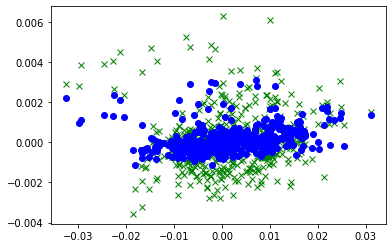

In [342]:
#HF and MP2 errors for all individual four-body terms

plt.plot(CCSDTF12b4_tot_F[:],CABS4_val_F[1,:,0]-CCSDTF12b4_tot_F[:],'gx')
plt.plot(CCSDTF12b4_tot_F[:],MP24_tot[:]-CCSDTF12b4_tot_F[:],'bo')
plt.show()

In [343]:
# Total MP2 and MP3 errors
print('Total MP2 error: ', np.sum(MP_mbe[0,:])-np.sum(CC_mbeQ5[3,:]))
print('Total MP3 error: ', np.sum(MP_mbe[1,:])-np.sum(CC_mbeQ5[3,:]))

Total MP2 error:  0.3918567961405577
Total MP3 error:  0.9142704744602432


In [344]:
# Estimate of MP4 interaction energy 
#2b and 3b terms from MP4, 4b terms from HF+CABS
print('Estimate of MP4 interaction energy: ', np.sum(MP_mbe[2,1:4])+np.sum(CC_mbeQ5[0,4:7]))

Estimate of MP4 interaction energy:  -4.8314437219583946


### MP2 correlation energies for 3b subsets

...and how they relate to ATM term.

Here we just show in a graph how the MP2 errors for 3b are negative (too weak repulsion) for clusters
with hydrogen bonded water molecules and are getting positive as the vertex angle increases.

Group  0 30 -0.5575934261112858
Group  1 60 -0.2655433970311526
Group  2 60 -0.0004569337433210441
Group  3 40 0.040912644983374116


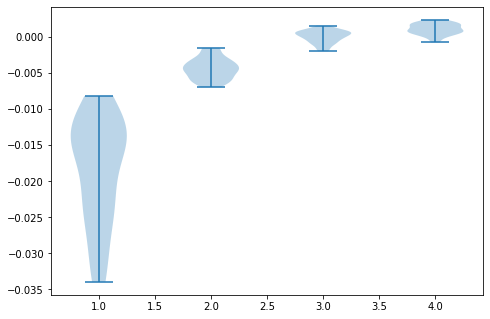

In [345]:
#calculate the MP2 errors wrt CCSD(T) for three-body groups
#CABS3_val_F_NN=np.zeros((190,4))

diff=np.zeros((190,4))
for i in range(4):
    for j in range(idx3_ok[i]):
        diff[j,i]=MP23_val_NN[j,i]-CCSDTF12b3_tot_F_NN[j,i]
    print('Group ', i, idx3_ok[i], np.sum(diff[:,i]) )
    
fig=plt.figure()
ax2 = fig.add_axes([0,0,1,1])
data=[diff[0:idx3_ok[0],0], diff[0:idx3_ok[1],1], diff[0:idx3_ok[2],2], diff[0:idx3_ok[3],3]]
bp2=ax2.violinplot(data)
plt.show()
#data+=[MP23_val_NN[0:idx3_ok[0],0],diff3_mp2_NNord[0:idx3_ok[1],1],diff3_mp2_NNord[0:idx3_ok[2],2],diff3_mp2_NNord[0:idx3_ok[3],3]]

### Two groups of dimers

This is pyplot version of Figure 1, errors of MPn methods versus CCSD(T)-F12 reference data

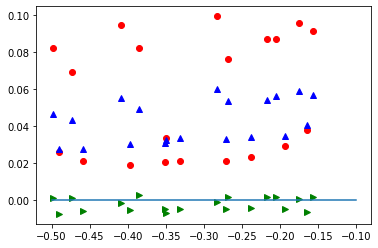

In [346]:
plt.plot(CCSDTF12b2_tot,MP2_tot-CCSDTF12b2_tot,'ro')
plt.plot(CCSDTF12b2_tot,MP3_tot-CCSDTF12b2_tot,'b^')
plt.plot(CCSDTF12b2_tot,MP4_tot-CCSDTF12b2_tot,'g>')

plt.plot([-0.5,-0.1],[0.0,0.0])
plt.show()

# Performance of RPA

## Dimers

### Table 6

In [347]:
# RPA energies
for xc in ['SCAN0','PBE0','SCAN','PBE','HF']:
    print('RPA(',xc, ')     ', np.sum(RPA_tot[methods[xc],0,:]))
    print('RPA(',xc, ')+RSE ', np.sum(RPA_tot[methods[xc],1,:]))
for xc in ['oepx','oep2sc']:
    print('RPA(',xc, ')     ', np.sum(RPA_oep[oep_m[xc],0,:]))
    print('RPA(',xc, ')+RSE ', np.sum(RPA_oep[oep_m[xc],1,:]))

RPA( SCAN0 )      -4.350363816667299
RPA( SCAN0 )+RSE  -5.360766165539584
RPA( PBE0 )      -4.142345416671978
RPA( PBE0 )+RSE  -5.40889445166321
RPA( SCAN )      -4.432773911897005
RPA( SCAN )+RSE  -6.4609842916652
RPA( PBE )      -3.8739801026457625
RPA( PBE )+RSE  -6.699209809368001
RPA( HF )      -2.983009825884056
RPA( HF )+RSE  -2.983009824555357
RPA( oepx )      -2.7660169999999997
RPA( oepx )+RSE  -4.470336
RPA( oep2sc )      -3.939989
RPA( oep2sc )+RSE  -6.372100999999998


In [348]:
# RPAc energies, use CBS extrapolated value
for xc in ['SCAN0','PBE0','SCAN','PBE','HF']:
    print('RPAc(',xc, ')     ', np.sum(RPA_val[methods[xc],2,:]))
    

RPAc( SCAN0 )      -9.741077975881769
RPAc( PBE0 )      -9.766641242326015
RPAc( SCAN )      -11.169213800958108
RPAc( PBE )      -11.56452199536839
RPAc( HF )      -6.814887207178057


In [349]:
# HF/EXX energies, use AVQZ value
for xc in ['SCAN0','PBE0','SCAN','PBE','HF']:
    print('HF(',xc, ')     ', np.sum(EXX_val[methods[xc],1,:]))

HF( SCAN0 )      5.390714159214471
HF( PBE0 )      5.624295825654036
HF( SCAN )      6.736439889061102
HF( PBE )      7.690541892722627
HF( HF )      3.8318773812940012


In [350]:
# HF/EXX+RSE energies, AVQZ value
for xc in ['SCAN0','PBE0','SCAN','PBE','HF']:
    print('HF+RSE(',xc, ')     ', np.sum(EXX_val[methods[xc],1,:])+np.sum(RSE_val[methods[xc],1,:]))

HF+RSE( SCAN0 )      4.380311810342186
HF+RSE( PBE0 )      4.357746790662805
HF+RSE( SCAN )      4.708229509292906
HF+RSE( PBE )      4.865312186000388
HF+RSE( HF )      3.831877382622701


## Trimers

### Table 7

Values used to produce Table 7. RPA3_tot has indices [method, RSE or not, fragment]. The \_val arrays have indices [xc, basis set, fragment, subcluster]. The subcluster needs to be set to 0 to obtain the non-additive energy of the fragment, the other indices contain interaction energies of parts of the fragment (dimers, ...).


In [351]:
print('Method   PBE | PBE0 | SCAN | SCAN0 | HF  ')
print('RPA+RSE ', " ".join("{:.4f}".format(np.sum(RPA3_tot[ord,1,:])) for ord in range(0,5)) )
print('RPA     ', " ".join("{:.4f}".format(np.sum(RPA3_tot[ord,0,:])) for ord in range(0,5)) )
print('DFT/HF  ', " ".join("{:.4f}".format(np.sum(DFT3_val[ord,1,:,0])) for ord in range(0,5)) )
print('RPAc    ', " ".join("{:.4f}".format(np.sum(RPA3_val[ord,2,:,0])) for ord in range(0,5)) )
print('HF+RSE  ', " ".join("{:.4f}".format(np.sum(EXX3_val[ord,1,:,0])+np.sum(RSE3_val[ord,1,:,0])) for ord in range(0,5)) )
print('HF      ', " ".join("{:.4f}".format(np.sum(EXX3_val[ord,1,:,0])) for ord in range(0,5)) )

Method   PBE | PBE0 | SCAN | SCAN0 | HF  
RPA+RSE  0.9412 0.7406 0.4070 0.3988 0.5324
RPA      -2.0088 -0.2112 0.5947 0.6409 0.5324
DFT/HF   7.4506 4.3924 -0.5362 -0.1100 -0.2728
RPAc     2.3397 1.4555 0.6395 0.6553 0.8052
HF+RSE   -1.3985 -0.7149 -0.2325 -0.2565 -0.2728
HF       -4.3485 -1.6668 -0.0448 -0.0145 -0.2728


### Table 8

Which gives the RPA contributions divided into groups according to number of hydrogen bonds in fragment.

In [369]:
#we print the data stored in the mbe arrays
print('Method   2b |3b 1hb | 3b 0hb | 4b 2hb | 4b 1hb | 4b 0hb | Total  ')
print('HF+CABS ', " ".join("{:.3f}".format(CC_mbeQ5[0,ord]) for ord in range(1,7)), np.sum(CC_mbeQ5[0,:]) )
print('CC-F12 tot', " ".join("{:.3f}".format(CC_mbeQ5[3,ord]) for ord in range(1,7)), np.sum(CC_mbeQ5[3,:]) )
for xc in ['PBE','PBE0','SCAN','SCAN0','HF']:
    for rse in range(2):
        print('RPA(',xc,')',rse,'RSE     & $', "$ & $".join("{:.3f}".format((RPA_mbe[methods[xc],rse,ord])) for ord in range(1,7)) ,'$ & $ ',np.sum(RPA_mbe[methods[xc],rse,:]) ,'$\\\\')

Method   2b |3b 1hb | 3b 0hb | 4b 2hb | 4b 1hb | 4b 0hb | Total  
HF+CABS  3.827 -1.483 1.210 0.164 0.471 -0.083 4.107197891504827
CC-F12 tot -6.310 -0.398 1.434 0.056 0.552 -0.051 -4.718095521926804
RPA( PBE ) 0 RSE     & $ -3.874$ & $-1.849$ & $-0.160$ & $1.152$ & $1.551$ & $0.374 $ & $  -2.8057869236714215 $\\
RPA( PBE ) 1 RSE     & $ -6.699$ & $-0.470$ & $1.411$ & $0.132$ & $0.705$ & $0.017 $ & $  -4.904339191808855 $\\
RPA( PBE0 ) 0 RSE     & $ -4.142$ & $-1.083$ & $0.872$ & $0.416$ & $0.847$ & $0.055 $ & $  -3.0359686858161967 $\\
RPA( PBE0 ) 1 RSE     & $ -5.409$ & $-0.608$ & $1.349$ & $0.090$ & $0.585$ & $-0.044 $ & $  -4.037806078802072 $\\
RPA( SCAN ) 0 RSE     & $ -4.433$ & $-0.721$ & $1.316$ & $-0.113$ & $0.539$ & $-0.071 $ & $  -3.483615204389226 $\\
RPA( SCAN ) 1 RSE     & $ -6.461$ & $-0.642$ & $1.049$ & $0.208$ & $0.725$ & $0.017 $ & $  -5.10396193430692 $\\
RPA( SCAN0 ) 0 RSE     & $ -4.350$ & $-0.668$ & $1.308$ & $-0.007$ & $0.561$ & $-0.052 $ & $  -3.2077625180458496

## Tetramers and n>4-body clusters

### Table 9

First four-body contributions, then 5- and higher contributions

In [352]:
print('Method   PBE | PBE0 | SCAN | SCAN0 ')
print('RPA+RSE ', " ".join("{:.4f}".format(np.sum(RPA4_tot[ord,1,:])) for ord in range(0,4)) )
print('RPA     ', " ".join("{:.4f}".format(np.sum(RPA4_tot[ord,0,:])) for ord in range(0,4)) )
print('DFT/HF  ', " ".join("{:.4f}".format(np.sum(DFT4_val[ord,1,:,0])) for ord in range(0,4)) )

#print(np.sum(RPA_mbe[0,0,4:7]))
#print(RPA_mbe)

Method   PBE | PBE0 | SCAN | SCAN0 
RPA+RSE  0.8537 0.6305 0.9501 0.7696
RPA      3.0770 1.3176 0.3545 0.5017
DFT/HF   -3.4636 -1.6772 1.9418 1.3465


In [353]:
print('Method   PBE | PBE0 | SCAN | SCAN0 ')
print('RPA+RSE ', " ".join("{:.4f}".format(RPA_sup[ord,1]-np.sum(RPA_mbe[ord,1,:])) for ord in range(0,4)) )
print('RPA     ', " ".join("{:.4f}".format(RPA_sup[ord,0]-np.sum(RPA_mbe[ord,0,:])) for ord in range(0,4)) )

print(RPA_sup[0,:])
print(RPA_mbe[0,:,:])

Method   PBE | PBE0 | SCAN | SCAN0 
RPA+RSE  -0.0857 0.0078 -0.0060 0.0123
RPA      -0.9242 -0.2640 0.1036 0.0378
[-3.73 -4.99]
[[ 0.         -3.8739801  -1.0238456  -0.9849528   1.15174537  1.55075073
   0.37449548]
 [ 0.         -6.69920981  0.35525191  0.58596007  0.13191714  0.70520967
   0.01653183]]


## Incremental approach

Here are the data obtained by using Eq. 11 from the manuscript. CCSD(T) interaction energies for small n-body contributions complemented with RPA terms for the higher-order contributions.

In [366]:
#array to store RPA corrected MBE
RPA_cortd=np.zeros((5,2,7))
#array to store % errors
RPA_cortd_pct=np.zeros((5,2,7))
#array to store MP2 corrected MBE
MP_cortd=np.zeros((7))
HF_cortd=np.zeros((7))
MP_cortd_pct=np.zeros((7))
HF_cortd_pct=np.zeros((7))
#start with the RPA supermolecular calculation
RPA_act=RPA_sup
CC_act=0.
RPA_cortd[:,:,0]=RPA_act
MP_cortd[0]=-4.31
HF_cortd[0]=4.11

#calculate correction scheme based on different inputs for the different orders (2b, 3b 1hb, 3b 0hb, ...)
for order in range(1,7):
    for xc in range(5):
        for rse in range(2):
            #take the previous energy as a reference and subtract the RPA part and add the CC part
            RPA_cortd[xc,rse,order]=RPA_cortd[xc,rse,order-1]+CC_mbeQ5[3,order]-RPA_mbe[xc,rse,order]
            #-4.71 is our reference value
            RPA_cortd_pct[xc,rse,order]=(RPA_cortd[xc,rse,order]+4.71)/(-4.71)*100
    #calculate MP2- and HF-based corrections
    MP_cortd[order]=MP_cortd[order-1]+CC_mbeQ5[3,order]-MP_mbe[0,order]
    HF_cortd[order]=HF_cortd[order-1]+CC_mbeQ5[3,order]-CC_mbeQ5[0,order]
    MP_cortd_pct[order]=(MP_cortd[order]+4.71)/(-4.71)*100
    HF_cortd_pct[order]=(HF_cortd[order]+4.71)/(-4.71)*100

    
print(RPA_mbe[1,1,:])
    
#print the results
print('CC/RPA PBE       ', RPA_cortd[0,0,:])
print('CC/RPA PBE+RSE   ', RPA_cortd[0,1,:])
print('CC/RPA PBE0      ', RPA_cortd[1,0,:])
print('CC/RPA PBE0+RSE  ', RPA_cortd[1,1,:])
print('CC/RPA SCAN      ', RPA_cortd[2,0,:])
print('CC/RPA SCAN+RSE  ', RPA_cortd[2,1,:])
print('CC/RPA SCAN0     ', RPA_cortd[3,0,:])
print('CC/RPA SCAN0+RSE ', RPA_cortd[3,1,:])
#print('CC/RPA HF        ', RPA_cortd[4,0,:]) #we don't have the full cluster data
print('CC/MP2           ', MP_cortd)
print('CC/HF            ', HF_cortd)

print('CC-F12 tot       ', " ".join("{:.3f}".format(np.sum(CC_mbeQ5[3,0:ord+1])) for ord in range(7)) )


[ 0.         -5.40889445 -0.60817431  1.3487677   0.08986102  0.58456139
 -0.04392743]
CC/RPA PBE        [-3.73       -6.16644704 -4.71567436 -3.12232334 -4.2177322  -5.21684588
 -5.6423086 ]
CC/RPA PBE+RSE    [-4.99       -4.60121734 -4.52954217 -4.50710402 -4.58268464 -4.73625726
 -4.80375633]
CC/RPA PBE0       [-3.3        -5.46808173 -4.78288125 -4.22151392 -4.58070137 -4.87618137
 -4.98212684]
CC/RPA PBE0+RSE   [-4.03       -4.9315327  -4.72158391 -4.63680079 -4.67032529 -4.70324964
 -4.71028944]
CC/RPA SCAN       [-3.38       -5.25765324 -4.9349942  -4.81699786 -4.64781495 -4.63487774
 -4.61448032]
CC/RPA SCAN+RSE   [-5.11       -4.95944286 -4.71539922 -4.33106995 -4.48270528 -4.65641126
 -4.72413359]
CC/RPA SCAN0      [-3.17       -5.13006333 -4.86074033 -4.735595   -4.67186205 -4.68162449
 -4.680333  ]
CC/RPA SCAN0+RSE  [-4.18       -5.12966098 -4.79928427 -4.49315776 -4.5987332  -4.68106188
 -4.70576324]
CC/MP2            [-4.31       -5.42880439 -4.87121096 -4.64612328 -4.706

In [370]:
#So for RPA(PBE0)+RSE the difference after adding 2b and 3b 1hb is 
print(RPA_cortd[1,1,2])

-4.721583905523378
